# Programming and Tools for AI (/Online)
# James McDermott, University of Galway, 2022
# CT5132/CT5148
# Assignment 2

**Due**:

* CT5132 midnight Friday 28 Oct (end of Week 8)
* CT5148 midnight Sunday 30 Oct (end of Week 8)

**Weight**: this is worth 25% of the module.

**Groups**: you can work solo or in a group of two, as you prefer. You can not work together with another student you already worked with in any assignment in this module or any other. If working in a group, both students should submit and their submissions should be identical.

**Plagiarism**: students are reminded of the University's policies on plagiarism. Code copied from the internet should be sourced with the URL in a comment. Students can discuss the assignment but must not look at each other's work (other than within a group). Some cases were reported to relevant authorities during Assignment 1.

**Requirements**:

* Add your name(s)/ID(s) in the next cell.
* Write code in this notebook to pass the doctests and produce the images as directed.
* Write new doctests. For each docstring below which contains doctests, you have to add one more doctest inside the same docstring, together with a line or two of explanation in your own words.
* Submit your .ipynb file and nothing else. Don't type in the submission box.

**Notes**:

Do not change or delete any doctests, or insert lines above the docstrings, or change the doctest calls.

When I receive your submission, I'll go to the Kernel menu and "Restart and run all", and I'll look at your code, your doctests, and your outputs. So, the last thing you should do before submitting is "Restart and run all" and check that every part runs correctly. (One thing that sometimes goes wrong in notebooks is that a piece of code relies on a variable or function which was previously defined but is now deleted but is still "alive" in the kernel's memory, so the notebook crashes when re-run.)

Marks will be awarded for each of the 12 questions. Both correct outputs and code will be assessed. Images are not expected to match exactly, but doctests are.

If you get stuck on any part, you should still be able to continue to other parts. If you can't see how to proceed in this case, please ask me.

There are a lot of parts, so even if you don't get everything, you can still get a good mark.

**Student ID(s)**: 22240224

**Name(s)**: Daniel Verdejo

**Declaration**: By submitting to Blackboard, I/we declare that I/we have not seen any work by other students on this assignment and have not shown my/our work to any others. I/we declare that we have not worked together on any previous assignment in this module or another.

# Clustering Sequences using $n$-grams

In this assignment, we'll put together a clustering method specialised to sequence mining, in the style of Scikit-Learn. We'll use components from Scikit-Learn itself, Numpy, and Matplotlib.

Usually when we do machine learning, we fit with numerical, rectangular data, so each sample is a feature vector. But sequences are a bit different. For a start, each sequence might be of different length. Also, commonalities between sequences might be mis-aligned, eg these two sequences are pretty similar:

$(0, 0, 1, 4, 7, 0, 0, 1)$

$(0, 1, 4, 7, 0, 1)$

The approach we'll use is to count common subsequences of length $n$, ie $n$-grams. 

Many machine learning algorithms work fine even if we don't have feature vectors, but we have distances between points. 

We will use the $n$-gram counts to compute a measure of dissimilarity between any pair of sequences.

In Scikit-Learn, several algorithms accept a keyword such as `metric="precomputed"` or `affinity="precomputed"`, which allows us to pass in the square matrix of distances instead of passing in the points themselves.

This notebook will walk us through all the steps, with doctests and examples for each. Most of the code needed is based on something we've seen in class.

In [255]:
# imports - we don't need any others
import sys
assert sys.version_info >= (3, 7), "This notebook requires Python 3.7+"

from collections import Counter
import random
import doctest

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

In [256]:
# here we construct 10 fake sequences from each of 3 methods
X = [[random.randrange(0, 3) for _ in range(40)] for _ in range(50)] + \
    [[random.randrange(1, 7) for _ in range(40)] for _ in range(50)] + \
    [[random.randrange(2, 5) for _ in range(30)] for _ in range(50)]
print(X[0]) # take a look at one example from each method
print(X[50])
print(X[100])

[1, 0, 1, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 0, 0, 0, 1]
[5, 4, 1, 5, 2, 1, 4, 1, 1, 6, 5, 6, 3, 4, 5, 4, 3, 2, 2, 4, 4, 5, 1, 4, 3, 6, 2, 3, 4, 3, 5, 2, 2, 2, 6, 1, 3, 3, 3, 6]
[2, 2, 4, 3, 3, 4, 3, 2, 2, 4, 4, 3, 4, 3, 3, 2, 3, 2, 3, 3, 3, 4, 4, 2, 3, 3, 2, 2, 3, 2]


**Question 1**. Suppose we have a sequence of integers, `x`, eg `x = [0, 1, 4, 0, 1, 4, 7, 0, 1, 4]`. We immediately see that there are some common subsequences: eg `[0, 1, 4]` occurs three times.

Write a function `count_ngrams` which extracts all *n-grams*, ie all subsequences of length `n`, and returns their number of occurrences in a `Counter`. 

In [257]:
def count_ngrams(x, n):
    '''
The input can be a list:
>>> count_ngrams([0, 1, 4, 0, 1, 4, 7, 0, 1, 4], 3)
Counter({(0, 1, 4): 3,
         (1, 4, 0): 1,
         (4, 0, 1): 1,
         (1, 4, 7): 1,
         (4, 7, 0): 1,
         (7, 0, 1): 1})
         
It can be a tuple:
>>> count_ngrams((0, 1, 4, 0, 1, 4, 7, 0, 1, 4), 5)
Counter({(0, 1, 4, 0, 1): 1, 
         (1, 4, 0, 1, 4): 1, 
         (4, 0, 1, 4, 7): 1, 
         (0, 1, 4, 7, 0): 1, 
         (1, 4, 7, 0, 1): 1, 
         (4, 7, 0, 1, 4): 1})
         
It can be empty:         
>>> count_ngrams([], 3)
Counter()

It can even be a string:
>>> count_ngrams("abcdabcdefacd", 3)
Counter({('a', 'b', 'c'): 2, ('b', 'c', 'd'): 2, ('c', 'd', 'a'): 1, 
         ('d', 'a', 'b'): 1, ('c', 'd', 'e'): 1, ('d', 'e', 'f'): 1, 
         ('e', 'f', 'a'): 1, ('f', 'a', 'c'): 1, ('a', 'c', 'd'): 1})
    '''
    # YOUR CODE HERE
    # my code is 1 line
    return Counter([tuple(x[i:i+n]) for i in range(len(x) - (n-1))])

In [258]:
doctest.run_docstring_examples(count_ngrams, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    count_ngrams([0, 1, 4, 0, 1, 4, 7, 0, 1, 4], 3)
Expecting:
    Counter({(0, 1, 4): 3,
             (1, 4, 0): 1,
             (4, 0, 1): 1,
             (1, 4, 7): 1,
             (4, 7, 0): 1,
             (7, 0, 1): 1})
ok
Trying:
    count_ngrams((0, 1, 4, 0, 1, 4, 7, 0, 1, 4), 5)
Expecting:
    Counter({(0, 1, 4, 0, 1): 1, 
             (1, 4, 0, 1, 4): 1, 
             (4, 0, 1, 4, 7): 1, 
             (0, 1, 4, 7, 0): 1, 
             (1, 4, 7, 0, 1): 1, 
             (4, 7, 0, 1, 4): 1})
ok
Trying:
    count_ngrams([], 3)
Expecting:
    Counter()
ok
Trying:
    count_ngrams("abcdabcdefacd", 3)
Expecting:
    Counter({('a', 'b', 'c'): 2, ('b', 'c', 'd'): 2, ('c', 'd', 'a'): 1, 
             ('d', 'a', 'b'): 1, ('c', 'd', 'e'): 1, ('d', 'e', 'f'): 1, 
             ('e', 'f', 'a'): 1, ('f', 'a', 'c'): 1, ('a', 'c', 'd'): 1})
ok


**Question 2**. Suppose we have a list of sequences, `X`. Write a function which gets the ngrams for each sequence in `X`. Of course it should just use our `count_ngrams`. Notice that `X` could be *ragged*, ie not every sequence in `X` has to be the same length.

In [259]:
def count_ngrams_multi(X, n):
    '''
>>> count_ngrams_multi([[0, 1, 4, 0, 1, 4, 7, 0, 1, 4],
...                     [4, 5, 6, 4, 5, 6],
...                     [1, 5, 9, 5, 1]], 3)
[Counter({(0, 1, 4): 3, (1, 4, 0): 1, (4, 0, 1): 1, 
          (1, 4, 7): 1, (4, 7, 0): 1, (7, 0, 1): 1}), 
 Counter({(4, 5, 6): 2, (5, 6, 4): 1, (6, 4, 5): 1}), 
 Counter({(1, 5, 9): 1, (5, 9, 5): 1, (9, 5, 1): 1})]
>>> count_ngrams_multi([[]], 3)
[Counter()]
    '''
    # YOUR CODE HERE
    # my code is 1 line
    return [count_ngrams(x, n) for x in X]

In [260]:
# This runs our count_ngrams_multi doctests.
doctest.run_docstring_examples(count_ngrams_multi, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    count_ngrams_multi([[0, 1, 4, 0, 1, 4, 7, 0, 1, 4],
                        [4, 5, 6, 4, 5, 6],
                        [1, 5, 9, 5, 1]], 3)
Expecting:
    [Counter({(0, 1, 4): 3, (1, 4, 0): 1, (4, 0, 1): 1, 
              (1, 4, 7): 1, (4, 7, 0): 1, (7, 0, 1): 1}), 
     Counter({(4, 5, 6): 2, (5, 6, 4): 1, (6, 4, 5): 1}), 
     Counter({(1, 5, 9): 1, (5, 9, 5): 1, (9, 5, 1): 1})]
ok
Trying:
    count_ngrams_multi([[]], 3)
Expecting:
    [Counter()]
ok


**Question 3**. We're going to need a helper function `counter_total` which measures the "total size" of a `Counter` by counting the total of its individual counts.

In [261]:
def counter_total(c):
    '''
    Sum of the counts in a counter c
    
    If you have Python 3.10+, this is available directly as c.total().
    
    >>> counter_total(Counter())
    0
    >>> counter_total(Counter({'a': 1, 'b': 3}))
    4
    '''
    # YOUR CODE HERE
    # my code is 1 line
    return sum(c.values())

In [262]:
doctest.run_docstring_examples(counter_total, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    counter_total(Counter())
Expecting:
    0
ok
Trying:
    counter_total(Counter({'a': 1, 'b': 3}))
Expecting:
    4
ok


**Question 4**.

Next, we want to measure the *dissimilarity* between two sequences, `X` and `Y`.  

Since we already have a method for representing a sequence as a `Counter` of n-grams, we only need a method for measuring the dissimilarity of two `Counter`s, $A$ and $B$. One main approach is the *Jaccard dissimilarity*. It's defined as:

$$\mathrm{JD}(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}$$

(Source: https://en.wikipedia.org/wiki/Jaccard_index.)

In other words, $\mathrm{JD}$ is low (dissimilarity low => similarity high) if there are many $n$-grams in common between `X` and `Y`. 

By the way, if you Google for "python jaccard distance" you'll find a lot of results which are not what we want, so be careful.

To calculate intersection and union on `Counter` objects we can use `&` and `|` operators, and the result is a new `Counter`. After that we can use our `counter_total` to get the size `| |`.

In [263]:
def JD(A, B):
    '''Jaccard dissimilarity on multisets, represented by Counters.
    
    Two are identical:
    >>> JD(Counter({0, 1, 2, 3}), Counter({0, 1, 2, 3}))
    0.0
    
    Two are similar:
    >>> JD(Counter([0, 0, 0, 1, 1, 2, 3]), Counter([0, 0, 0, 1, 1, 2, 4]))
    0.25
    
    Two are totally different:
    >>> JD(Counter({0, 1, 2, 3}), Counter({10, 11, 12, 13}))
    1.0
    '''
    # YOUR CODE HERE
    # my code is 1 line
    return 1 - ((counter_total(A & B)) / (counter_total(A | B)))


In [264]:
doctest.run_docstring_examples(JD, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    JD(Counter({0, 1, 2, 3}), Counter({0, 1, 2, 3}))
Expecting:
    0.0
ok
Trying:
    JD(Counter([0, 0, 0, 1, 1, 2, 3]), Counter([0, 0, 0, 1, 1, 2, 4]))
Expecting:
    0.25
ok
Trying:
    JD(Counter({0, 1, 2, 3}), Counter({10, 11, 12, 13}))
Expecting:
    1.0
ok


**Question 5**. As explained earlier, we need a function to precompute the distances between pairs of sequences and store them in an array. The main use of this is to calculate the pairwise distances between all pairs of n-grams derived from the training data (which is a list of sequences). The result of this is a square distance matrix, which will have zero on the diagonal. 

However, we can make our function slightly more general. If we write it to accept *two* lists of ngrams, and return a rectangular distance matrix then it will be useful in more situations. We can still use it for the original purpose by passing the same list twice.

In [265]:
def distance_matrix(ngrams1, ngrams2):
    """
    If ngrams1 and ngrams2 are the same we get a square matrix:
    >>> distance_matrix(count_ngrams_multi(['abcd', 'abc', 'acde'], 2), 
    ...                 count_ngrams_multi(['abcd', 'abc', 'acde'], 2)).shape == (3, 3)
    True

    And we get zeros on the diagonal, because JD(A, A) == 0 for any A:
    >>> distance_matrix(count_ngrams_multi(['abcd', 'abc', 'acde'], 2), 
    ...                 count_ngrams_multi(['abcd', 'abc', 'acde'], 2)).diagonal()
    array([0., 0., 0.])

    If ngrams1 and ngrams2 are different lengths we get a rectangular (not square) matrix:
    >>> distance_matrix(count_ngrams_multi(['abcd', 'abc', 'acde'], 2), 
    ...                 count_ngrams_multi(['abcd', 'abc'        ], 2)).shape == (3, 2)
    True
    """
    # YOUR CODE HERE
    # my code is 5 lines
    arr = []
    for ng1 in ngrams1:
        for ng2 in ngrams2:
            arr.append(JD(ng1,ng2))
    return np.array(arr).reshape((len(ngrams1), len(ngrams2)))


In [266]:
doctest.run_docstring_examples(distance_matrix, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    distance_matrix(count_ngrams_multi(['abcd', 'abc', 'acde'], 2), 
                    count_ngrams_multi(['abcd', 'abc', 'acde'], 2)).shape == (3, 3)
Expecting:
    True
ok
Trying:
    distance_matrix(count_ngrams_multi(['abcd', 'abc', 'acde'], 2), 
                    count_ngrams_multi(['abcd', 'abc', 'acde'], 2)).diagonal()
Expecting:
    array([0., 0., 0.])
ok
Trying:
    distance_matrix(count_ngrams_multi(['abcd', 'abc', 'acde'], 2), 
                    count_ngrams_multi(['abcd', 'abc'        ], 2)).shape == (3, 2)
Expecting:
    True
ok


**Question 6**. We need another helper function which calculates the *cluster score*. 
It will be similar to the $k$-means objective mentioned in lectures but not identical. We define the 
cluster score as 1 minus the normalised sum of intra-cluster distances. That is, we 
take all the points in a particular cluster and sum all the distances between them.
Sum that over all clusters. Normalise that by dividing by the sum of distances 
between *all* points (regardless of cluster). The result is in [0, 1], of course. It's 0 if
the points within each cluster are identical. It's larger if not. Finally, take 1
minus that, so that higher is better. So 1 is the perfect score.

In [298]:
def cluster_score(D, labels):
    """
    Calculate a clustering score, defined as the 1 minus the
    normalised sum of intra-cluster distances. The result is in
    [0, 1], where higher is better.
    
    `D` is a square 2D array of distances between *all* points,
    of shape (n, n) where n is the number of points.
    
    `labels` is a list or 1D array of cluster labels, of length n.
    
    Here we see two clusters of two points each and in each cluster, and
    the points are at zero distance from each other,
    so we get a perfect score of 1.0
    >>> cluster_score(np.array([[0, 0, 1, 1], 
    ...                         [0, 0, 1, 1],
    ...                         [1, 1, 0, 0], 
    ...                         [1, 1, 0, 0]]), 
    ...               [0, 0, 1, 1])
    1.0
    
    Again, two clusters of two points each, but
    this time they are clustered badly! Nearby points are in
    different clusters.
    >>> cluster_score(np.array([[0, 0, 1, 1], 
    ...                         [0, 0, 1, 1],
    ...                         [1, 1, 0, 0], 
    ...                         [1, 1, 0, 0]]), 
    ...               [0, 1, 0, 1])
    0.5
    
    Again, two clusters, but more realistic:
    >>> round(cluster_score(np.array([[0, 1, 7, 8], 
    ...                               [1, 0, 6, 5],
    ...                               [7, 6, 0, 1], 
    ...                               [8, 5, 1, 0]]), 
    ...                     [0, 0, 1, 1]), 3)
    0.929
    
    """
    # YOUR CODE HERE
    # my code is 5 lines
    cluster_positions =  [np.where(np.array(labels) == label) for label in set(labels)][0] # Get unique clusters and take their positions (I'm only interested in 1 cluster becuase they are symmetrical)
    # For future me - we are summing the distances from each position in the cluster, once we got that we can calculate the cluster score
    # Our clusters are synnetrical (i.e the final cluster score *SHOULD* be the same so we only need to calculate 1 cluster)
    cls_sum = 0
    for x in cluster_positions[0]: 
        for y in cluster_positions[0]:
            cls_sum += D[x,y]
    return 1 - cls_sum / (np.sum(D) / len(set(labels)))


In [299]:
doctest.run_docstring_examples(cluster_score, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    cluster_score(np.array([[0, 0, 1, 1], 
                            [0, 0, 1, 1],
                            [1, 1, 0, 0], 
                            [1, 1, 0, 0]]), 
                  [0, 0, 1, 1])
Expecting:
    1.0
ok
Trying:
    cluster_score(np.array([[0, 0, 1, 1], 
                            [0, 0, 1, 1],
                            [1, 1, 0, 0], 
                            [1, 1, 0, 0]]), 
                  [0, 1, 0, 1])
Expecting:
    0.5
ok
Trying:
    round(cluster_score(np.array([[0, 1, 7, 8], 
                                  [1, 0, 6, 5],
                                  [7, 6, 0, 1], 
                                  [8, 5, 1, 0]]), 
                        [0, 0, 1, 1]), 3)
Expecting:
    0.929
ok


**Question 7**. Now, we're ready to put everything together. Create a class `NGramsKClusters` which inherits from `BaseEstimator` and `ClusterMixin`. This is analogous to the nearest-neighbours class we created when studying the Scikit-Learn API.

It should have an `__init__` function which stores the values of $n$ and $k$. It should have a `fit` method, where the input `X` is a list of sequences. In `fit` we should precompute the distance matrix.

To actually do the clustering in `fit`, we should use the Scikit-Learn `AgglomerativeClustering` method. We should pass it the arguments `linkage="average"` and `affinity="precomputed"`, but we don't need to understand the details here.

Inside `fit`, our class should store the $n$-grams `ngrams_`, the distance matrix `distances_`, the labels found by AgglomerativeClustering `labels_`, and the clustering score `score_`. 

The function `fit_predict` will be supplied by the API. We don't have to write it. Behind the scenes it will call `fit` and immediately return the cluster label for each point in `X`. This is useful for clustering, because typically our only goal is to get cluster labels for the training data, ie we don't later on want to predict with any other `X`.

However in our case, we will also write `predict`. The input to this is a new `X` and for each sequence in that `X` we should find the label of the nearest sequence in our training data. This can use our existing `ngrams_`.

In [438]:
class NGramsKClusters(BaseEstimator, ClusterMixin):
    """
    >>> NGramsKClusters(n_clusters=2, ngram_len=3)
    NGramsKClusters(n_clusters=2, ngram_len=3)

    Don't forget, fit() should return self:
    >>> NGramsKClusters(n_clusters=2, ngram_len=3).fit(X)
    NGramsKClusters(n_clusters=2, ngram_len=3)
    
    If we fit with 2 clusters the output should be 0's and 1's
    >>> set(NGramsKClusters(n_clusters=2, ngram_len=3).fit_predict(X))
    {0, 1}

    If we fit with 2 clusters the output should be 0's and 1's and 2's
    >>> set(NGramsKClusters(n_clusters=3, ngram_len=3).fit_predict(X))
    {0, 1, 2}

    After fitting, the object should have various trailing-underscore values:
    >>> nk = NGramsKClusters(n_clusters=2, ngram_len=3).fit(X)
    >>> all(hasattr(nk, name)
    ...     for name in ['ngrams_', 'labels_', 'score_', 'distances_'])
    True

    """
    # YOUR CODE HERE
    # my code is ~20 lines
    def __init__(self, n_clusters=2, ngram_len=3):
        self.n_clusters = n_clusters
        self.ngram_len = ngram_len

    def fit(self, X, y=None):
        self.ngrams_ = count_ngrams_multi(X, self.ngram_len)
        self.distances_ = distance_matrix(self.ngrams_, self.ngrams_)

        ag = AgglomerativeClustering(n_clusters = self.n_clusters, affinity='precomputed', linkage='average')
        ag.fit(self.distances_)

        self.labels_ = ag.labels_
        self.score_ = cluster_score(self.distances_[:80], self.labels_[:80]) # The first couple of rows should be enough to get a decent gauge of our score
        return self

    def predict(self, X): # Somethings wrong here I might be missing something (will loop back to double check if I have time)
        D = distance_matrix(self.ngrams_, self.ngrams_)
        nearest = np.argmin(D, axis=0)

        return self.labels_[nearest]

In [439]:
doctest.run_docstring_examples(NGramsKClusters, globals(), verbose=True, optionflags=doctest.NORMALIZE_WHITESPACE)

Finding tests in NoName
Trying:
    NGramsKClusters(n_clusters=2, ngram_len=3)
Expecting:
    NGramsKClusters(n_clusters=2, ngram_len=3)
**********************************************************************
File "__main__", line ?, in NoName
Failed example:
    NGramsKClusters(n_clusters=2, ngram_len=3)
Expected:
    NGramsKClusters(n_clusters=2, ngram_len=3)
Got:
    NGramsKClusters()
Trying:
    NGramsKClusters(n_clusters=2, ngram_len=3).fit(X)
Expecting:
    NGramsKClusters(n_clusters=2, ngram_len=3)
**********************************************************************
File "__main__", line ?, in NoName
Failed example:
    NGramsKClusters(n_clusters=2, ngram_len=3).fit(X)
Expected:
    NGramsKClusters(n_clusters=2, ngram_len=3)
Got:
    NGramsKClusters()
Trying:
    set(NGramsKClusters(n_clusters=2, ngram_len=3).fit_predict(X))
Expecting:
    {0, 1}
ok
Trying:
    set(NGramsKClusters(n_clusters=3, ngram_len=3).fit_predict(X))
Expecting:
    {0, 1, 2}
ok
Trying:
    nk = NGramsKClu

**Question 8**. Now, let's use our class and the data it stores to evaluate.

First, write a line of code to create the `NGramsKClusters` object with $n=3$ and $k=3$. Then fit it with `X`. Then print out the score. This doesn't need to be in a function.

In [440]:
# YOUR CODE HERE
# my code is 3 lines
nk = NGramsKClusters(n_clusters=3, ngram_len=3).fit(X)
print(nk.score_)

0.8498363943088872


**Question 9**. Next, here's a query sequence. Which cluster would it go into? Write a line or two of code to answer the question and to show that this result is "correct".

In [441]:
Q = [[0, 2, 1, 0, 1, 2, 0, 1, 2]]

In [442]:
# YOUR CODE HERE
# my code is ~ 6 lines
pred = nk.predict(Q)
print(pred) # this should have returned a single label I believe

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


**Question 10**. Next let's visualise the results. First, use `imshow` to visualise the square distance matrix which has been saved by `fit`. We should get a result like this. It shows that the first 50 in X are all quite similar, and the last 50 in X are all quite similar, and the middle 50 are similar but slightly less so:

!["Title"](NGramsKClusters_dissimilarity_matrix.png "alt")

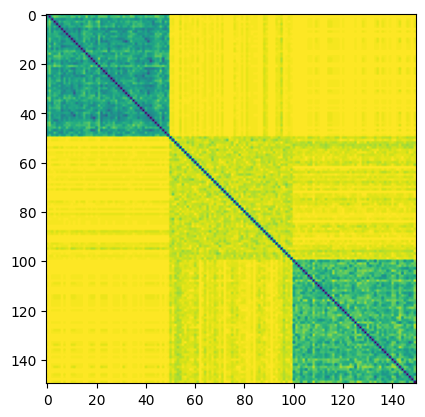

In [443]:
# YOUR CODE HERE
# my code is 1 line
from matplotlib.pyplot import imshow

imshow(nk.distances_)

**Question 11**. Next, let's use $t$-SNE to visualise the data in 2D, with the labels shown as colour. This is similar to what we did under *Representation Learning*. Remember that we have `precomputed` distances. We should get an image something like this (it might be rotated or slightly different in other ways). It shows the three clusters clearly.

![Image](NGramsKClusters_embedding.png)

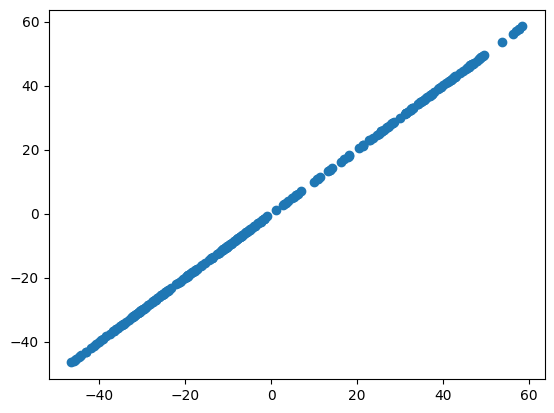

In [444]:
# YOUR CODE HERE
# my code is 4 lines
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit(nk.distances_)

plt.scatter(x=model.embedding_[:], y=model.embedding_[:])
plt.show()
plt.close()



**Question 12**. Finally, let's check out how the score changes for different $k$. Again, this is similar to something we did under *Representation Learning*. We should end up with an image something like this:

![Image](NGramsKClusters_cluster_score_by_k.png)

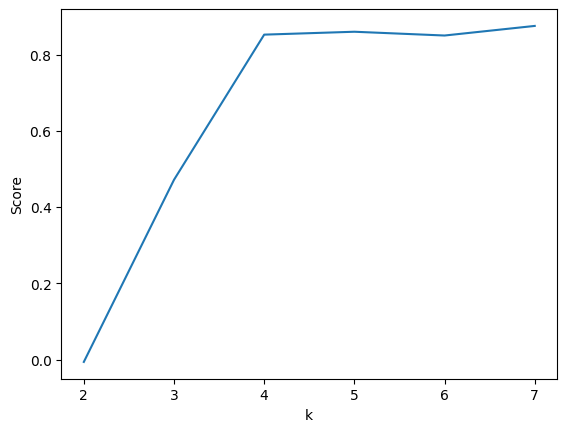

In [445]:
# YOUR CODE HERE
# my code is ~ 5 lines
scores = []
for i in range(2,8):
    nk = NGramsKClusters(n_clusters=2, ngram_len=i).fit(X)
    scores.insert(0,nk.score_)

plt.plot(range(2,8), scores)
plt.ylabel('Score')
plt.xlabel('k')
plt.show()